In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize as opt
from scipy.optimize import Bounds
import urllib
from sqlalchemy import create_engine
import json
import csv
import sympy as sm
from sympy import log
import cvxpy

In [2]:
def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    G=nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    pos = nx.shell_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

In [3]:
def func_graph(n, p):
    vector_c = []
    graph = nx.gnp_random_graph(n, p)
    A = nx.to_numpy_array(graph, dtype='int32')
    A = A+np.eye(n,dtype='int32')
#     nx.draw(graph, pos=nx.spring_layout(graph), node_color='g', with_labels=True)
#     plt.draw()
#     plt.show()
    return A

In [4]:
def func_comb(n):
    list_combinations,tmp = [],[]
    for i in range(1, pow(2, n)):
        tmp.append(bin(i)[2:].zfill(n))
        list_combinations.append([int(i) for i in bin(i)[2:].zfill(n)])
    list_combinations=np.array(list_combinations)
    return list_combinations

In [5]:
def equations(x,comb):
    n = len(comb)
    c = 0.01
    f = [0 for i in range(0,n)]
    for l, x_l in enumerate(comb):
        if(x_l==1):
#                 для каждого игрока из S берем вектор его сосдей из А, для построения (e1+e0+...+1)
            for i, x_i in enumerate(A[l]*comb.T):
                if (x_i==1):
                    f[l]+=1/(sum(A[i]*x.T)+1)
            f[l]=f[l]-c
        else:
            f[l]=1/(sum(A[l]*x.T)+1)-c
    return f

In [6]:
def equations_log(comb,x):
    n = len(comb)
    c = 0.01
    f = [0 for i in range(0,n)]
    for l, x_l in enumerate(comb):
        if(x_l==1):
            f[l]=np.log(sum(A[l]*x.T)+1)-c*x[l]

    return sum(f)

In [69]:
n = 5
x0 = np.array(np.zeros(n,))
tmp = []
list_combinations = func_comb(n)
results = []
list_res = []
results_comb = []
results_comb1 = []
results_prob = []
step = 0.01
bounds = (np.zeros(n,),[np.inf for i in range(0,n)])
for p in np.arange(0.5,1.0,step):
    for k in range(0,200):
        A = func_graph(n, p)
        for comb in list_combinations:
            res = opt.least_squares(lambda x: equations(x,comb), [1 for i in range(0,n)], bounds= bounds)       
            results.append(equations_log(comb,res.x))
            results_comb1.append(comb)
            results_comb.append(k)
            results_prob.append(p)
            

   Value_Func  Number_Iteration        Coalition  Prob Coalition_as_string
0    4.497414                 0  [0, 0, 0, 0, 1]   0.5         [0 0 0 0 1]
1    4.053462                 0  [0, 0, 0, 1, 0]   0.5         [0 0 0 1 0]


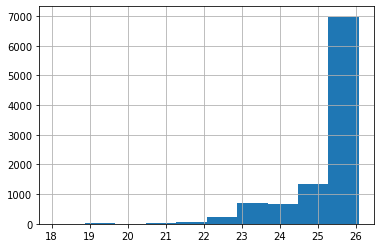

In [70]:
data_results=pd.DataFrame(data = results,columns = ['Value_Func'], index = range(200*50*len(list_combinations)))
data_results['Number_Iteration'] = results_comb
data_results['Coalition'] = results_comb1
data_results['Prob'] = results_prob
data_results['Coalition_as_string'] = data_results['Coalition'].astype('str')
print(data_results.head(2))

data_results[data_results['Coalition_as_string'] == '[1 1 1 1 1]']['Value_Func'].hist()

In [62]:
data_results.describe()

,Value_Func,Number_Iteration,Prob
count,31000.000000,31000.000000,31000.000000
mean,12.273098,99.500000,0.700000
std,5.443481,57.735236,0.141424
min,3.609498,0.000000,0.500000
25%,8.803495,49.750000,0.600000
50%,12.444869,99.500000,0.700000
75%,14.998304,149.250000,0.800000
max,26.083040,199.000000,0.900000


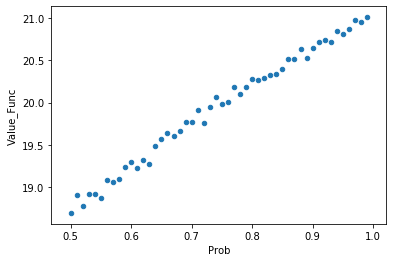

In [75]:
coalition = data_results.loc[data_results['Coalition_as_string'] == '[1 1 1 0 1]' ]
coalition.groupby('Prob', as_index=False).agg({'Value_Func':'mean'}).plot(kind='scatter', x = 'Prob', y = 'Value_Func')

In [73]:
def func2(comb,x):
    rez = 0
    for i, x_i in enumerate(comb):
        if x_i == 1:
            rez+=np.log(A[i].dot(comb.T*x.T)+1)-x_i*0.01*x[i]                           
    return -rez

In [177]:
def func_sqrt(comb,x):
    rez = 0
    for i, x_i in enumerate(comb):
        if x_i == 1:
            rez+=pow(A[i].dot(comb.T*x.T),0.5)-x_i*0.01*x[i]                           
    return -rez

In [79]:
n = 5
x0 = np.array(np.zeros(n,))
tmp = []
list_combinations = func_comb(n)
results_mm = []
list_res = []
results_comb_mm = []
results_comb1_mm = []
results_prob_mm =[]
bounds = Bounds(np.zeros(n,),[np.inf for i in range(0,n)])
step =0.01
for p in np.arange(0.5,1.0,step):
    for k in range(0,10):
        A = func_graph(n, p)
        for comb in list_combinations:
            res = opt.minimize(lambda x: func2(comb,x), x0, method='TNC', bounds = bounds)
            results_mm.append(-func2(comb,res.x))
            results_comb1_mm.append(comb)
            results_comb_mm.append(k)
            results_prob_mm.append(p)


   Value_Func  Number_Iteration        Coalition  Prob Coalition_as_string
0     3.61517                 0  [0, 0, 0, 0, 1]   0.5         [0 0 0 0 1]
1     3.61517                 0  [0, 0, 0, 1, 0]   0.5         [0 0 0 1 0]


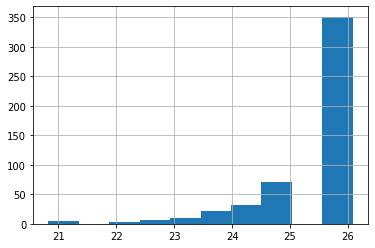

In [80]:
data_results_mm=pd.DataFrame(data = results_mm,columns = ['Value_Func'], index = range(10*50*len(list_combinations)))
data_results_mm['Number_Iteration'] = results_comb_mm
data_results_mm['Coalition'] = results_comb1_mm
data_results_mm['Prob'] = results_prob_mm
data_results_mm['Coalition_as_string'] = data_results_mm['Coalition'].astype('str')
print(data_results_mm.head(2))

data_results_mm[data_results_mm['Coalition_as_string'] == '[1 1 1 1 1]']['Value_Func'].hist()

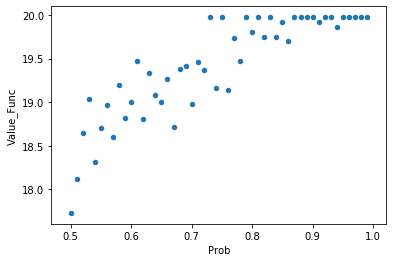

In [83]:
coalition_mm = data_results_mm.loc[data_results['Coalition_as_string'] == '[1 1 1 0 1]' ]
coalition_mm.groupby('Prob', as_index=False).agg({'Value_Func':'mean'}).plot(kind='scatter', x = 'Prob', y = 'Value_Func')

рассмотрим одну коалицию


In [99]:
n = 5
x0 = np.array(np.zeros(n,))
tmp = []
list_combinations = func_comb(n)
results_mm = []
list_res = []
results_comb_mm = []
results_comb1_mm = []
results_prob_mm =[]
bounds = Bounds(np.zeros(n,),[np.inf for i in range(0,n)])
step = 0.001
comb = np.array([1, 1, 1, 0, 1])
for p in np.arange(0.5,1.0,step):
    for k in range(0,1000):
        A = func_graph(n, p)
#         for comb in list_combinations:
        res = opt.minimize(lambda x: func2(comb,x), x0, method='TNC', bounds = bounds)
        results_mm.append(-func2(comb,res.x))
        results_comb1_mm.append(comb)
        results_comb_mm.append(k)
        results_prob_mm.append(p)


In [184]:
n = 5
x0 = np.array(np.zeros(n,))
tmp = []
list_combinations = func_comb(n)
results_mm1 = []
list_res = []
results_comb_mm1 = []
results_comb1_mm1 = []
results_prob_mm1 =[]
bounds = Bounds(np.zeros(n,),[np.inf for i in range(0,n)])
step =0.01
for p in np.arange(0.01,1.0,step):
    for k in range(0,10):
        A = func_graph(n, p)
        for comb in list_combinations:
            res = opt.minimize(lambda x: func_sqrt(comb,x), x0, method='TNC', bounds = bounds)
            results_mm1.append(-func_sqrt(comb,res.x))
            results_comb1_mm1.append(comb)
            results_comb_mm1.append(k)
            results_prob_mm1.append(p)

In [183]:
res

     fun: -624.9998402669286
     jac: array([0., 0., 0., 0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 55
     nit: 10
  status: 0
 success: True
       x: array([12477.06410991, 12477.06410991, 12477.0639949 , 12502.41933006,
       12503.21165373])

   Value_Func  Number_Iteration        Coalition  Prob Coalition_as_string
0        25.0                 0  [0, 0, 0, 0, 1]  0.01         [0 0 0 0 1]
1        25.0                 0  [0, 0, 0, 1, 0]  0.01         [0 0 0 1 0]


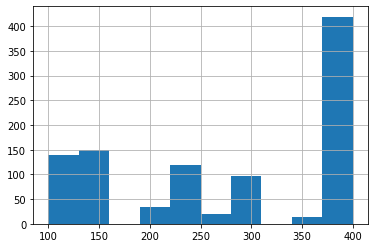

In [185]:
data_results_mm1=pd.DataFrame(data = results_mm1,columns = ['Value_Func'], index = range(len(results_mm1)))
data_results_mm1['Number_Iteration'] = results_comb_mm1
data_results_mm1['Coalition'] = results_comb1_mm1
data_results_mm1['Prob'] = results_prob_mm1
data_results_mm1['Coalition_as_string'] = data_results_mm1['Coalition'].astype('str')
print(data_results_mm1.head(2))

data_results_mm1[data_results_mm1['Coalition_as_string'] == '[1 1 1 0 1]']['Value_Func'].hist()

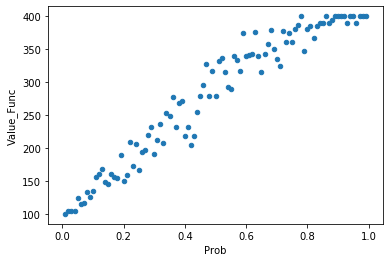

In [189]:
coalition_mm = data_results_mm1[data_results_mm1['Coalition_as_string'] == '[1 1 0 1 1]']
coalition_mm.groupby('Prob', as_index=False).agg({'Value_Func':'mean'}).plot(kind='scatter', x = 'Prob', y = 'Value_Func')

In [168]:
M=10
for m in range(0,M):
    p2 = m/M+(m*pow(M-m,0.5))/(M*pow(M-1,0.5))
    p1 = m/M-(m*pow(M-m,0.5))/(M*pow(M-1,0.5))
    print('p2= ' , p2, 'p1 = ', p1)

p2=  0.0 p1 =  0.0
p2=  0.2 p1 =  0.0
p2=  0.38856180831641274 p1 =  0.011438191683587312
p2=  0.5645751311064591 p1 =  0.035424868893540906
p2=  0.7265986323710905 p1 =  0.07340136762890964
p2=  0.8726779962499649 p1 =  0.12732200375003505
p2=  1.0 p1 =  0.19999999999999996
p2=  1.104145188432738 p1 =  0.29585481156726195
p2=  1.1771236166328254 p1 =  0.42287638336717465
p2=  1.2 p1 =  0.6000000000000001


   Value_Func  Number_Iteration        Coalition  Prob Coalition_as_string
0   15.836975                 0  [1, 1, 1, 0, 1]   0.5         [1 1 1 0 1]
1   18.594561                 1  [1, 1, 1, 0, 1]   0.5         [1 1 1 0 1]


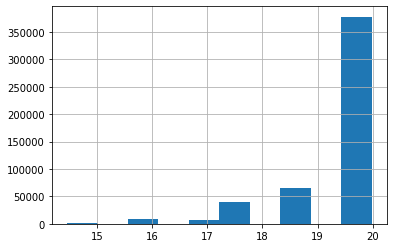

In [100]:
data_results_mm=pd.DataFrame(data = results_mm,columns = ['Value_Func'], index = range(1000*500))
data_results_mm['Number_Iteration'] = results_comb_mm
data_results_mm['Coalition'] = results_comb1_mm
data_results_mm['Prob'] = results_prob_mm
data_results_mm['Coalition_as_string'] = data_results_mm['Coalition'].astype('str')
print(data_results_mm.head(2))

data_results_mm[data_results_mm['Coalition_as_string'] == '[1 1 1 0 1]']['Value_Func'].hist()

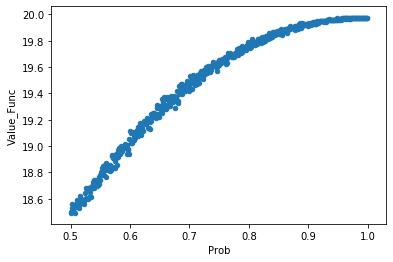

In [103]:
coalition_mm = data_results_mm
coalition_mm.groupby('Prob', as_index=False).agg({'Value_Func':'mean'}).plot(kind='scatter', x = 'Prob', y = 'Value_Func')

maxmin

In [104]:
n = 5
x0 = np.array(np.zeros(n,))
tmp = []
list_combinations = func_comb(n)
results = []
list_res = []
results_comb = []
results_comb1 = []
results_prob = []
step = 0.001
bounds = (np.zeros(n,),[np.inf for i in range(0,n)])
comb = np.array([1, 1, 1, 0, 1])
for p in np.arange(0.5,1.0,step):
    for k in range(0,1000):
        A = func_graph(n, p)
        res = opt.least_squares(lambda x: equations(x,comb), [1 for i in range(0,n)], bounds= bounds)       
        results.append(equations_log(comb,res.x))
        results_comb1.append(comb)
        results_comb.append(k)
        results_prob.append(p)
            

   Value_Func  Number_Iteration        Coalition  Prob Coalition_as_string
0   18.240592                 0  [1, 1, 1, 0, 1]   0.5         [1 1 1 0 1]
1   16.331977                 1  [1, 1, 1, 0, 1]   0.5         [1 1 1 0 1]


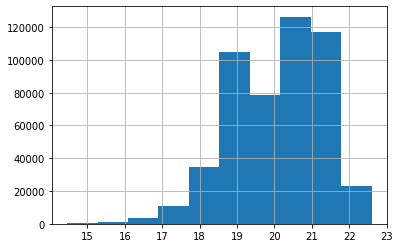

In [106]:
data_results=pd.DataFrame(data = results,columns = ['Value_Func'], index = range(1000*500))
data_results['Number_Iteration'] = results_comb
data_results['Coalition'] = results_comb1
data_results['Prob'] = results_prob
data_results['Coalition_as_string'] = data_results['Coalition'].astype('str')
print(data_results.head(2))

data_results[data_results['Coalition_as_string'] == '[1 1 1 0 1]']['Value_Func'].hist()

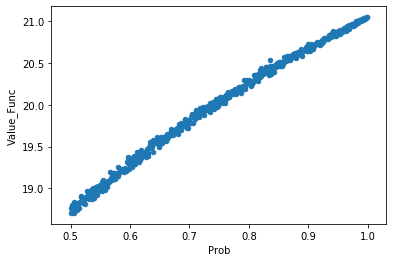

In [107]:
coalition = data_results
coalition.groupby('Prob', as_index=False).agg({'Value_Func':'mean'}).plot(kind='scatter', x = 'Prob', y = 'Value_Func')

SyntaxError: invalid syntax (<ipython-input-124-095f91572995>, line 1)